In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import log
from sklearn import linear_model

#comment below if not using ipython notebook
%matplotlib inline

In [2]:
#!pip -q install visualkeras
import visualkeras

2025-08-03 19:12:29.648434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754228549.769290  106627 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754228549.798851  106627 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-03 19:12:29.991940: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### let's load the data into a dataframe


In [3]:
data  = pd.read_csv('Assignment2.data', sep='\t')
data.head()

,SpringPos,StockPrice
0,2.27,3.48
1,6.38,2.99
2,8.61,5.86
3,8.65,1.79
4,13.17,3.47


In [4]:
data.describe()

,SpringPos,StockPrice
count,226.000000,226.000000
mean,3.785221,14.187743
std,10.704778,7.447450
min,-19.910000,0.670000
25%,-3.960000,8.355000
50%,4.195000,13.970000
75%,11.295000,19.632500
max,26.100000,30.050000


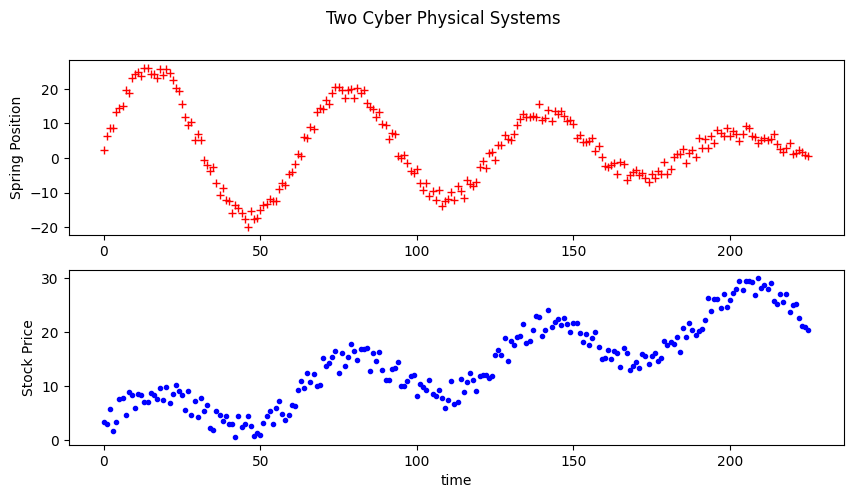

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Two Cyber Physical Systems')
fig.set_figwidth(10)
fig.set_figheight(5)

ax1.plot(data.SpringPos, 'r+')
ax1.set_ylabel('Spring Position')
ax2.plot(data.StockPrice, 'b.')
ax2.set_ylabel('Stock Price')
ax2.set_xlabel('time')

plt.show()

## Fit a linear model on the dataset

In [6]:
y2 = pd.DataFrame({"x":range(226), "y":data.StockPrice})
y2.head()

,x,y
0,0,3.48
1,1,2.99
2,2,5.86
3,3,1.79
4,4,3.47


### transform the data into matrices

In [7]:
yy = np.array(y2.y) 
xx = np.expand_dims(y2.x, 1)

### run the closed form solution to estimate the beta parameter.

In [8]:
numerator = np.matmul(np.transpose(xx), yy)
denom = np.matmul(np.transpose(xx), xx)
denom_inv = np.linalg.inv(denom)
beta = np.matmul(denom_inv, numerator)
print("Beta = ", beta[0])
sse = np.sum((xx*beta[0] - np.expand_dims(yy,1))**2)
print("SSE = ", sse)

Beta =  0.11899412514961837
SSE =  3850.335433080234


### as we will be reusing the above procedure often, let's make it a function

In [9]:
# estimate the value of the beta vector assuming that X is made of independent features.
def estimateBeta(X, y):
    numerator = np.matmul(np.transpose(X), y)
    denom = np.matmul(np.transpose(X), X)
    denom_inv = np.linalg.inv(denom)
    beta = np.matmul(denom_inv, numerator)
    return beta

# create a helper that would estimate yhat from X and beta.
def predict(beta, X):
    # reshape the input to a matrix, if it is appearing like an 1d array.
    if len(X.shape) != 2:
        X = np.expand_dims(X,1)
    # convert the beta list in to an array.
    beta = np.array(beta)
    # perform estimation of yhat.
    return np.matmul(X, beta)

# compute the sum of squared error between y and yhat.
def SSE(y, yhat):
    return np.sum((y-yhat)**2)

### Let's plot the raw data and the regression line on the same plot

Text(0.5, 0, 'Time')

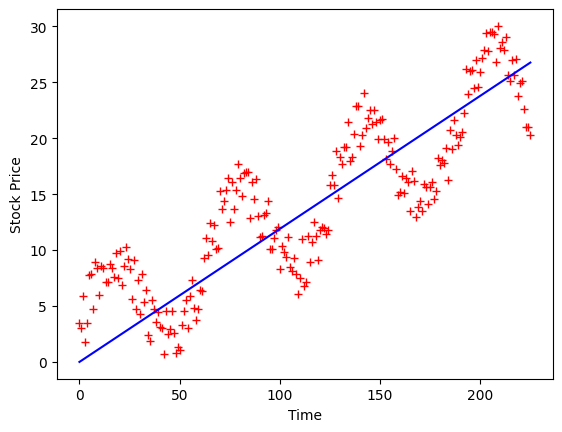

In [10]:
plt.plot(y2.x, y2.y, 'r+')
yhat1 = predict(beta, y2.x)
plt.plot(y2.x, yhat1, 'b-')  # yhat = y2.x*beta[0]
plt.ylabel('Stock Price')
plt.xlabel('Time')

### let's add an intercept (bias) to the data and check if the SSE drops further.

In [11]:
y2df = pd.DataFrame({"bias":np.ones(226), "x":range(226), "y":data.StockPrice})
yy = np.array(y2df.y) 
xx = np.array(y2df[["bias","x"]])
y2df.head()

,bias,x,y
0,1.0,0,3.48
1,1.0,1,2.99
2,1.0,2,5.86
3,1.0,3,1.79
4,1.0,4,3.47


### estimate the beta params and compute the loss again

In [12]:
beta2 = estimateBeta(xx, yy)
print("beta =", beta2)
yhat2 = predict(beta2, xx)
loss = SSE(yy, yhat2)
print("SSE =", loss)

beta = [3.18244786 0.09782485]
SSE = 3274.298469663405


### interesting! the loss has dropped with a little bit on intercept.  Let's plot it side by side.

Text(0.5, 0, 'Time')

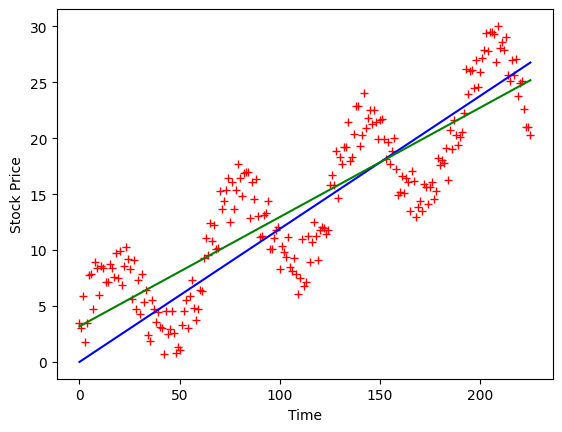

In [13]:
plt.plot(y2df.x, y2df.y, 'r+')
plt.plot(y2df.x, yhat1, 'b-')
plt.plot(y2df.x, yhat2, 'g-')
plt.ylabel('Stock Price')
plt.xlabel('Time')

### Let's model the periodicity

Let's borrow the slope information from the fit to set up the scale of the time axis.

Instead of using $x$ in integer scale, we shall use the floating point scale as $x_1 \leftarrow \beta_0 * x$

Likewise, let's create a new data dimension to capture the periodicity as $x_2 \leftarrow sin(x_1)$

Based on the expanded feature space, now let's try to model $\hat{y} = m_1 x_1 + m_2 x_2$, note that we don't have to use the intercept $c$ as our previous linear model passed through the origin.


### create a feature space appropriately

In [14]:
x1 = round(y2.x*beta2[1],2)
x2 = np.sin(x1)

y21 = pd.DataFrame({"bias":np.ones(226),"x":range(226), "x1":x1, "x2":x2, "y":data.StockPrice})
y21.head(10)

,bias,x,x1,x2,y
0,1.0,0,0.00,0.000000,3.48
1,1.0,1,0.10,0.099833,2.99
2,1.0,2,0.20,0.198669,5.86
3,1.0,3,0.29,0.285952,1.79
4,1.0,4,0.39,0.380188,3.47
5,1.0,5,0.49,0.470626,7.73
6,1.0,6,0.59,0.556361,7.83
7,1.0,7,0.68,0.628793,4.70
8,1.0,8,0.78,0.703279,8.97
9,1.0,9,0.88,0.770739,8.43


### create the data matrices from the data frame

In [15]:
xx = np.array(y21[['bias', 'x1', 'x2']])
yy = np.array(y2.y) 

In [16]:
beta3 = estimateBeta(xx, yy)
print("Beta = ", beta3)
yhat3 = predict(beta3, xx)
loss = SSE(yy, yhat3) #np.sum((np.matmul(xx,beta) - yy)**2)
print("SSE = ", loss)

Beta =  [2.74436632 1.00020159 4.82388129]
SSE =  701.3625743495965


### Let's plot the raw data and the regression line on the same plot

Text(0.5, 0, 'Time')

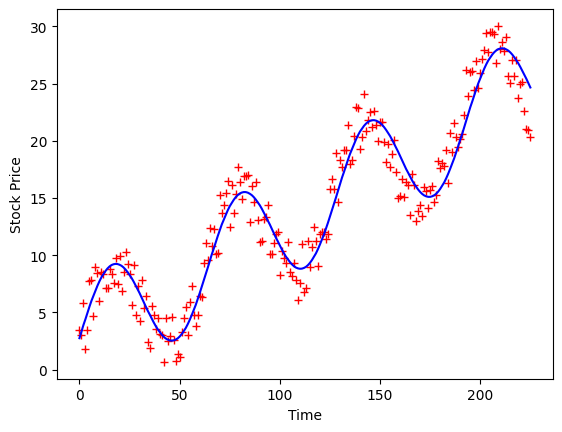

In [17]:
plt.plot(y2.x, y2.y, 'r+')
plt.plot(y2.x, yhat3, 'b-')
plt.ylabel('Stock Price')
plt.xlabel('Time')

### we were able to see the sin(x) from the visual.  what if we can't visualize? let's try the polynomial fit.

In [18]:
x1 = round(y2.x*beta2[1],2)

y21 = pd.DataFrame({"bias":np.ones(226),"x":range(226), "x1":x1, "y":data.StockPrice})
y21.head(10)

,bias,x,x1,y
0,1.0,0,0.00,3.48
1,1.0,1,0.10,2.99
2,1.0,2,0.20,5.86
3,1.0,3,0.29,1.79
4,1.0,4,0.39,3.47
5,1.0,5,0.49,7.73
6,1.0,6,0.59,7.83
7,1.0,7,0.68,4.70
8,1.0,8,0.78,8.97
9,1.0,9,0.88,8.43


### create the data matrices from the data frame

In [19]:
# here we don't need the explicit bias feature column, as polynomial features would include it already (x^0 = 1)
xx = np.array(y21[['x1']])
yy = np.array(y2.y) 

### let's use the polynomial features generator instead of manually doing it.

In [20]:
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree = 50)   # 10, 11
X_poly = poly_transformer.fit_transform(xx)

### fit the model and estimate the loss

In [21]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_poly, yy)
print("Intercept=", model.intercept_, "Beta = ", model.coef_)
yhat4 = model.predict(X_poly)

#beta4 = estimateBeta(X_poly, yy)
#print("Beta = ", beta4)
#yhat4 = predict(beta4, X_poly)

loss = SSE(yy, yhat4)
print("SSE = ", loss)

Intercept= 11.474642529013542 Beta =  [-1.06171580e-055  2.25050010e-054  3.34040933e-057  5.75402230e-061
  5.59427495e-063  1.10232970e-065  2.15637650e-101  1.29766935e-095
  2.05624764e-094  3.29371967e-093  5.31953270e-092  8.64523316e-091
  1.41161019e-089  2.31275017e-088  3.79791848e-087  6.24530511e-086
  1.02750517e-084  1.69004297e-083  2.77699720e-082  4.55521601e-081
  7.45408777e-080  1.21597940e-078  1.97601623e-077  3.19639258e-076
  5.14266303e-075  8.22244660e-074  1.30524466e-072  2.05499525e-071
  3.20519668e-070  4.94600052e-069  7.53975538e-068  1.13346574e-066
  1.67695361e-065  2.43579832e-064  3.46336716e-063  4.80326321e-062
  6.46866806e-061  8.41135406e-060  1.04827084e-058  1.23972055e-057
  1.37220165e-056  1.39320913e-055  1.25764030e-054  9.57116965e-054
  5.52885602e-053  1.82828800e-052 -4.46830729e-053  4.24589337e-054
 -2.00348872e-055  4.71424990e-057 -4.43130470e-059]
SSE =  5859.376404290878


### Let's plot the raw data and the regression line on the same plot

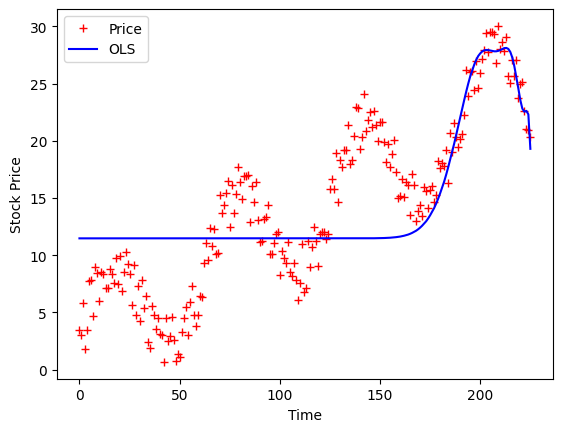

In [22]:
plt.plot(y2.x, y2.y, 'r+')
plt.plot(y2.x, yhat4, 'b-')
plt.ylabel('Stock Price')
plt.xlabel('Time')
plt.legend(['Price', 'OLS'], loc='upper left')
plt.show()

### Brilliant, how to I find the best degree automatically without performing a linear search!

In [23]:
from sklearn.linear_model import Lasso, Ridge
model5 = Lasso(alpha=500, max_iter=50000).fit(X_poly, yy)
#model5 = Ridge(alpha=5220).fit(X_poly,yy)
print("Beta =", model5.coef_)
yhat5 = model5.predict(X_poly)
loss = SSE(yy, yhat5)
print("SSE =", loss)

Beta = [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.23457505e-04  6.41066638e-05 -5.00453235e-06 -9.79342429e-08
 -7.34194177e-10  7.01900019e-11  5.70660175e-12  2.94593403e-13
  1.23876577e-14  4.44651873e-16  1.32976499e-17  2.81341868e-19
 -4.81288180e-22 -5.14583566e-22 -3.99266834e-23 -2.30098408e-24
 -1.15738350e-25 -5.34667275e-27 -2.31725753e-28 -9.50443771e-30
 -3.69230332e-31 -1.34910135e-32 -4.54691203e-34 -1.34596965e-35
 -2.98223430e-37 -4.17799332e-40  5.12227162e-40  4.39817165e-41
  2.77180373e-42  1.53263050e-43  7.85151987e-45  3.81476534e-46
  1.77812014e-47  7.99524711e-49  3.47393981e-50  1.45627365e-51
  5.85713545e-53  2.23340753e-54  7.87355753e-56  2.41406741e-57
  5.17792424e-59 -4.70872659e-61 -1.56867472e-61 -1.35435280e-62
 -9.15993261e-64 -5.55786862e-65 -3.16850061e-66]
SSE = 2444.6441748495045


/store/venv/da5401/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.289e+03, tolerance: 1.248e+00
  model = cd_fast.enet_coordinate_descent(


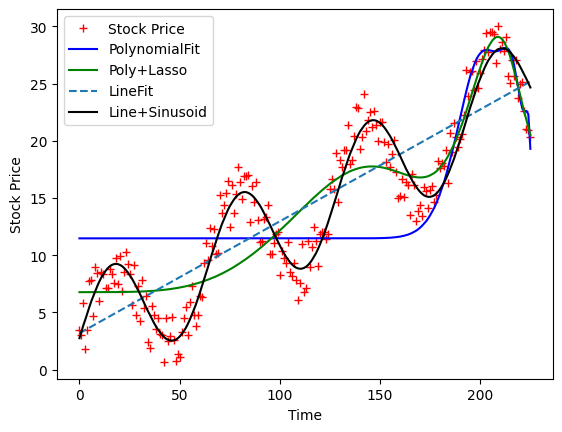

In [24]:
plt.ylabel('Stock Price')
plt.xlabel('Time')
plt.plot(y2.x, y2.y, 'r+')
plt.plot(y2.x, yhat4, 'b-')
plt.plot(y2.x, yhat5, 'g-')
plt.plot(y2.x, yhat2, '--')
plt.plot(y2.x, yhat3, 'k')
plt.legend(['Stock Price', 'PolynomialFit', 'Poly+Lasso', 'LineFit', 'Line+Sinusoid'], loc='upper left')
plt.show()

### what if closed form is not possible?  Gradient descent comes to the rescue.

Let's consider solving the LineFit problem in the Gradient Descent style.

As long as our mathematical model of the system is differentiable (gradients are computable), our loss function $\mathcal{L} = (y-\hat{y})^2$ remains differentiable.

Our linear model is given by $\hat{y} = \beta_0 + \beta_1 x = X^\top\beta$ and the loss is given by $\mathcal{L} = [y - (\beta_0 + \beta_1 x)]^2 = [y-X^\top\beta]^\top[y-X^\top\beta]$

The average loss gradients for the full dataset are given by $\frac{\partial\mathcal{L}}{\partial\beta_0} = \frac{-2}{N} \sum (y-\hat{y}) $ and $\frac{\partial\mathcal{L}}{\partial\beta_1} = \frac{-2}{N} \sum X^\top(y-\hat{y})$

### the GD algorithm

* Choose the mathematical model; ensure it's continuous and differentiable.
* Initialize the model parameters to random numbers.  Usually they are sampled from standard normal distribution.
* Compute the gradient of the loss based on the current model parametric setting.
* Update the parameters using $\beta_i \leftarrow \beta_i + \eta \frac{\partial\mathcal{L}}{\partial\beta_i}$
* Repeat the last two steps until the loss minimizes to the required target or it reaches a plateau.  If the loss increases, you have done something incorrectly.

### let's implement the gradient descent algorithm for the linefit solution.

In [25]:
from tqdm.auto import tqdm

class MyLineFitViaGD:
    def __init__(self, learning_rate=0.0001, n_iters=10_000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        # init parameters
        self.weights = np.random.randn(n_features)
        self.bias = np.random.randn(1)
        # gradient descent
        tq = tqdm(range(self.n_iters), desc="Iterations")
        for _ in  tq:
            # approximate y with linear combination of weights and x, plus bias
            y_predicted = np.matmul(X, self.weights) + self.bias

            # compute the gap between true and predicted outputs.
            diff = y_predicted - y
            loss = np.sum(diff * diff)
            
            # compute gradients
            dw = (1 / n_samples) * np.matmul(X.T, diff)
            db = (1 / n_samples) * np.sum(diff)
            # update parameters
            self.weights  = self.weights - self.lr * dw
            self.bias  = self.bias -  self.lr * db
            
            # display the loss on the progress bar.
            tq.set_postfix({"Loss":loss})
            
    @property
    def parameters(self):
        return self.bias, self.weights
            
    def predict(self, X):
        y_predicted = np.dot(X, self.weights) + self.bias
        return y_predicted

### recall our linear fit dataset and construct the dataset matrices again

In [26]:
print(y2df.head())
yy = np.array(y2df.y) 
xx = np.array(y2df[["x"]])  # no need for "bias", as our GD method factors it already.

   bias  x     y
0   1.0  0  3.48
1   1.0  1  2.99
2   1.0  2  5.86
3   1.0  3  1.79
4   1.0  4  3.47


### let's now build the model via Gradient Descent

In [27]:
gdmodel = MyLineFitViaGD(learning_rate=0.0000001, n_iters=5000)
# fit the model and estimate the yhat values.
gdmodel.fit(xx, yy)
#get the learned parameters from the model.
bias, weights = gdmodel.parameters
print("Bias =", bias, " Weights =", weights)
# use the model to predict the yhat values.
yhat6 = gdmodel.predict(xx)
# estimate the loss again and display
loss = SSE(yy, yhat6)
print ("Loss =", loss)

Iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

Bias = [-0.51633593]  Weights = [0.12247182]
Loss = 4052.4239018113058


### let's visualize and compare the linear fits estimated by OLS and GD.

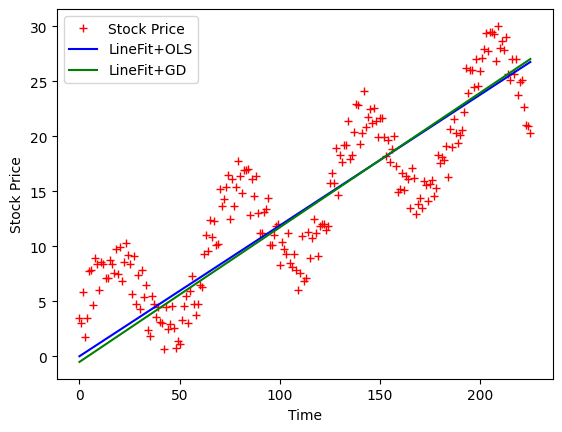

In [28]:
plt.plot(y2.x, y2.y, 'r+')
yhat1 = predict(beta, y2.x)
plt.plot(y2.x, yhat1, 'b-')
plt.plot(y2.x, yhat6, 'g-')
plt.ylabel('Stock Price')
plt.xlabel('Time')
plt.legend(['Stock Price', 'LineFit+OLS', 'LineFit+GD'], loc='upper left')
plt.show()

### let's try GD on our sinusoidal mathematical model

Now, our mathematical model of system is given by $\hat{y} = \beta_0 + \beta_1 x + \beta_2\sin(\beta_3 x)$

$\frac{\partial\mathcal{L}}{\partial\beta_0} = \frac{-2}{N} \sum (y-\hat{y})$

$\frac{\partial\mathcal{L}}{\partial\beta_1} = \frac{-2}{N} \sum X^\top(y-\hat{y})$

$\frac{\partial\mathcal{L}}{\partial\beta_2} = \frac{-2}{N} \sum \sin(\beta_3 X)^\top(y-\hat{y})$

$\frac{\partial\mathcal{L}}{\partial\beta_3} = \frac{-2}{N} \sum (\beta_2\cos(\beta_3 X) \cdot X)^\top(y-\hat{y})$

In [29]:
class MySinusoidFitViaGD:
    def __init__(self, learning_rate=0.0001, n_iters=10_000):
        self.lr = learning_rate
        self.n_iters = n_iters
        # init parameters
        self.m1 = np.abs(np.random.randn(1))
        self.m2 = np.abs(np.random.randn(1))
        # if I set this to random, convergence is not happening.  Choosing an initial value around 1.0 help convergence.
        self.m3 = [1] #np.abs(np.random.randn(1))
        self.bias = np.random.randn(1)
        print(f"Initial Params: Bias={self.bias[0]} M1={self.m1[0]}, M2={self.m2[0]}, M3={self.m3[0]}")
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        # gradient descent
        tq = tqdm(range(self.n_iters), desc="Iterations")
        # placeholder to capture the loss trend. 
        history = []

        for _ in  tq:
            # approximate y with linear combination of weights and x, plus bias
            y_predicted = self.predict(X)

            # compute the gap between true and predicted outputs.
            diff = y - y_predicted
            loss = SSE(y, y_predicted)
            
            # compute gradients
            dm1 = (-2 / n_samples) * np.matmul(X.T, diff)
            dm2 = (-2 / n_samples) * np.matmul(np.sin(self.m3*X).T, diff)
            dm3 = (-2 / n_samples) * np.matmul((X *self.m2* np.cos(self.m3*X)).T, diff)  
            db  = (-2 / n_samples) * np.sum(diff)
            
            # update parameters
            self.m1  = self.m1 - self.lr * dm1
            self.m2  = self.m2 - self.lr * dm2
            self.m3  = self.m3 - self.lr * dm3
            self.bias= self.bias -  self.lr * db
            
            # display the loss on the progress bar.
            tq.set_postfix({"Loss":loss})
            
            record = self.parameters
            record.append(loss)
            history.append(record)
            
        #print(history)
        #return history
        return np.array(history)
            
    @property
    def parameters(self):
        return [self.bias[0], self.m1[0][0], self.m2[0][0], self.m3[0][0]]
            
    def predict(self, X):
        y_predicted = self.bias + self.m1*X + self.m2*np.sin(self.m3*X)
        return y_predicted

In [30]:
# here we don't need the explicit bias feature column
xx = np.array(y21[['x1']])
yy = np.expand_dims(y2.y, 1) 
y21.head()

,bias,x,x1,y
0,1.0,0,0.00,3.48
1,1.0,1,0.10,2.99
2,1.0,2,0.20,5.86
3,1.0,3,0.29,1.79
4,1.0,4,0.39,3.47


### let's now build the model via Gradient Descent

Initial Params: Bias=0.5536095520738927 M1=0.23751673948167, M2=0.444624085656273, M3=1


Iterations:   0%|          | 0/15000 [00:00<?, ?it/s]

Bias =  1.8077427825242742  m1 = 1.0734799845896204  m2 = 4.0432514874615695  m3 = 1.0222074211012067
Loss = 637.6338178593398


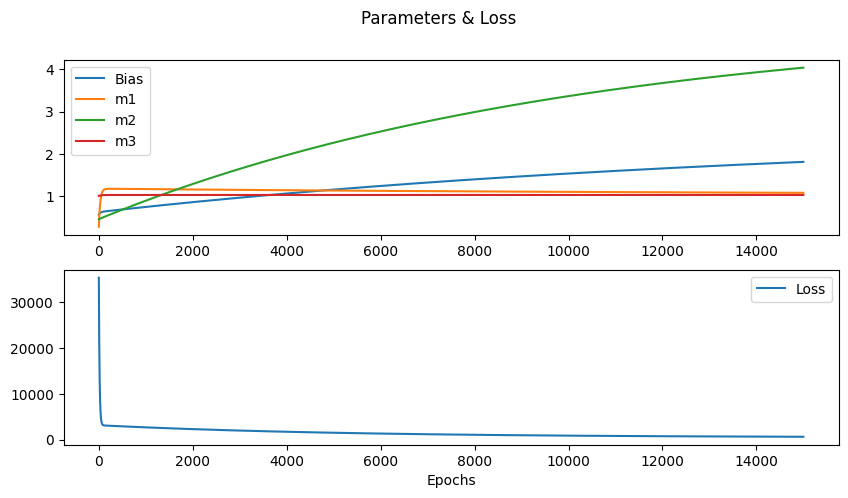

In [31]:
gdmodel = MySinusoidFitViaGD(learning_rate=0.0001, n_iters=15000)
# fit the model and estimate the yhat values.
history = gdmodel.fit(xx, yy)
#get the learned parameters from the model.
bias, w1, w2, w3 = gdmodel.parameters
print("Bias = ", bias, " m1 =", w1, " m2 =", w2, " m3 =", w3)
# use the model to predict the yhat values.
yhat7 = gdmodel.predict(xx)
# estimate the loss again and display
loss = SSE(yy, yhat7)
print ("Loss =", loss)

# let's plot the params and loss.
a1 = range(len(history))
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Parameters & Loss')
fig.set_figwidth(10)
fig.set_figheight(5)

ax1.plot(a1, history[:,0])
ax1.plot(a1, history[:,1])
ax1.plot(a1, history[:,2])
ax1.plot(a1, history[:,3])
ax1.legend(['Bias', 'm1', 'm2', 'm3'], loc='upper left')

ax2.plot(a1, history[:,4])
ax2.set_xlabel('Epochs')
ax2.legend(['Loss'], loc='upper right')
plt.show()

### let's visualize and compare the linear fits estimated by OLS and GD.

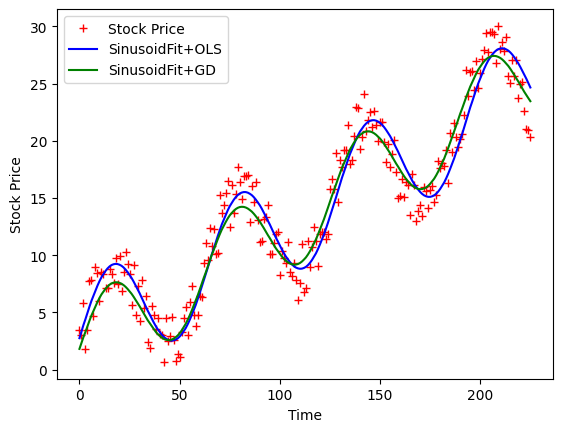

In [32]:
plt.plot(y2.x, y2.y, 'r+')
yhat1 = predict(beta, y2.x)
plt.plot(y2.x, yhat3, 'b-')
plt.plot(y2.x, yhat7, 'g-')
plt.ylabel('Stock Price')
plt.xlabel('Time')
plt.legend(['Stock Price', 'SinusoidFit+OLS', 'SinusoidFit+GD'], loc='upper left')
plt.show()

### let's try doing the same using Tensorflow, where gradients are computed automatically.

#### here, we don't have to hardcode the initial values.  The network learns all parameters automatically.

In [33]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K

In [34]:
class ParameterizedSinusoid(layers.Layer):
    def __init__(self, **kwargs):
        super(ParameterizedSinusoid, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.W = self.add_weight(shape=(1, input_shape[1]),
                                 initializer='random_normal',
                                 trainable=True)
        super(ParameterizedSinusoid, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, inputs):
        # compute sin(Wx)
        ax = tf.math.sin(tf.multiply(self.W, inputs))
        return ax
    
class Sinusoid(layers.Layer):
    def __init__(self, **kwargs):
        super(Sinusoid, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Sinusoid, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, inputs):
        # compute sin(x)
        ax = tf.math.sin(inputs)
        return ax

### let's create a custom activation function

In [35]:
# let's define a custom activation function "sinusoid"
def sinusoid(x):
    return tf.math.sin(x)

from keras.utils import get_custom_objects
get_custom_objects().update({'sinusoid': Activation(sinusoid)})

### reload the dataset 

In [36]:
#print(y2df.head())
#yy = np.array(y2df.y) 
#xx = np.array(y2df[["x1"]])  # no need for "bias", as our GD method factors it already.

print(y21.head())
yy = np.array(y21.y) 
xx = np.array(y21[["x1"]])  # no need for "bias", as our GD method factors it already.
reg_ds = tf.data.Dataset.from_tensor_slices((xx, yy)).batch(100)

   bias  x    x1     y
0   1.0  0  0.00  3.48
1   1.0  1  0.10  2.99
2   1.0  2  0.20  5.86
3   1.0  3  0.29  1.79
4   1.0  4  0.39  3.47


I0000 00:00:1754228556.639690  106627 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9058 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:07:00.0, compute capability: 6.1


### create a neural network for the sinusoidal feature based regression fit

In [37]:
inputs = layers.Input((1,), dtype=tf.float32, name='input')
d1 = layers.Dense(1, name='m3', activation=Activation(sinusoid), use_bias=False)(inputs)  # "sinusoid"
d2 = layers.Dense(1, name='m1', use_bias=True)(inputs)
d3 = layers.Dense(1, name='m2', use_bias=False)(d1)
output = layers.add((d2, d3), name='output')
model = tf.keras.Model(inputs, output, name='regressor')
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')
model.summary()
#visualkeras.graph_view(model)

Model: "regressor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m3 (Dense)          │ (None, 1)         │          1 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m1 (Dense)          │ (None, 1)         │          2 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m2 (Dense)          │ (None, 1)         │          1 │ m3[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Add)        │ (None, 1)         │          0 │ m1[0][0],         │
│                     │                   │            │ m2[0][0]          │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4 (16.00 B)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 0 (0.00 B)

### layers visualization

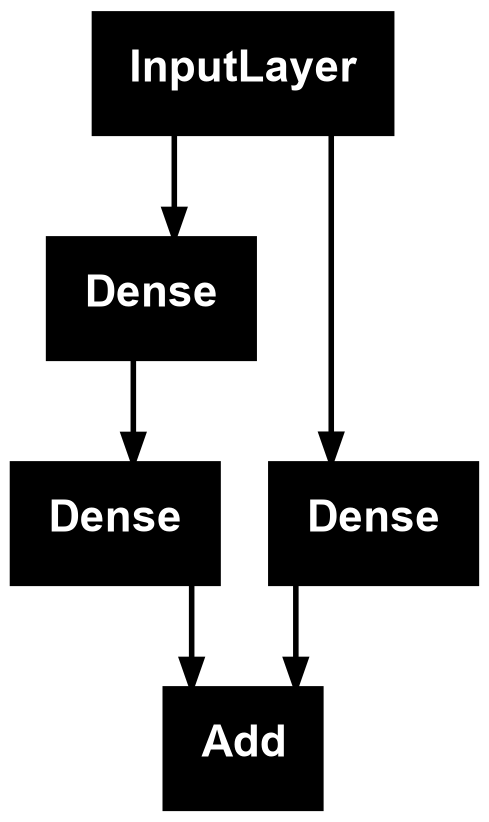

In [38]:
from keras.utils import plot_model
plot_model(model)

### learn the network.  If the loss does not go below 10, restart training!

0epoch [00:00, ?epoch/s]

I0000 00:00:1754228557.932812  106809 service.cc:148] XLA service 0x7630a0005090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754228557.932844  106809 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-08-03 19:12:37.956244: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754228558.030251  106809 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754228558.250145  106809 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


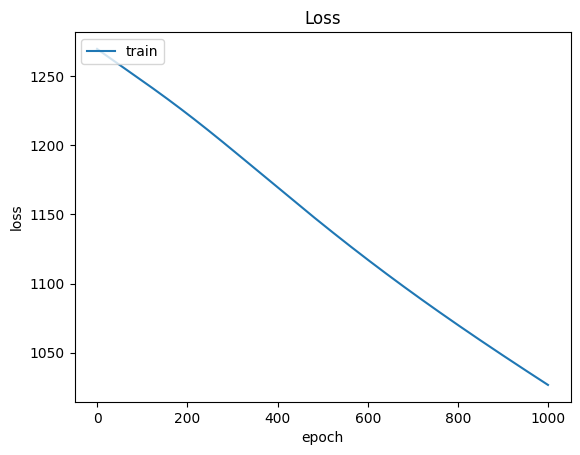

[<KerasVariable shape=(1, 1), dtype=float32, path=m3/kernel>,
 <KerasVariable shape=(1, 1), dtype=float32, path=m1/kernel>,
 <KerasVariable shape=(1,), dtype=float32, path=m1/bias>,
 <KerasVariable shape=(1, 1), dtype=float32, path=m2/kernel>]

In [39]:
from tqdm.keras import TqdmCallback

history = model.fit(reg_ds, epochs = 1000, verbose=0, callbacks=[TqdmCallback(verbose=0)])
yhat8 = model.predict(reg_ds)

plt.plot(history.history['loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

model.weights

### plot and compare the fits through OLS and TF/GD

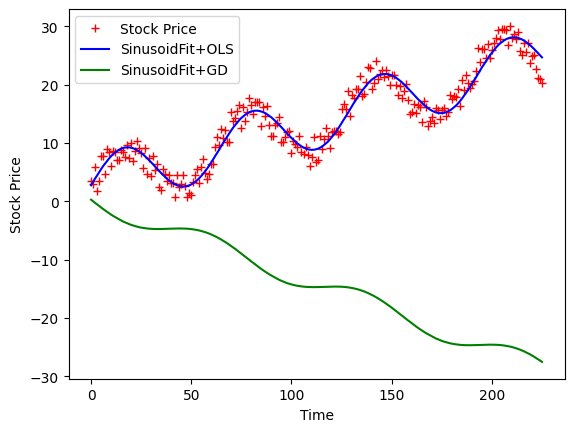

In [40]:
plt.plot(y2.x, y2.y, 'r+')
yhat1 = predict(beta, y2.x)
plt.plot(y2.x, yhat3, 'b-')
plt.plot(y2.x, yhat8, 'g-')
plt.ylabel('Stock Price')
plt.xlabel('Time')
plt.legend(['Stock Price', 'SinusoidFit+OLS', 'SinusoidFit+GD'], loc='upper left')
plt.show()

### let's try using locally weighted regression

Instead of fitting a single regression line, we find a nearest points to the given data point X using a kernel function (to compute weights) and fit the model for it, we do this for every single point, therfore this model results in smooth curve.

$h(x_0) = x_0^\top\hat\beta(x_0)$

$\hat\beta(x_0)=\arg\min_\beta\sum_{x,y}w(x,x_0)(y-x^\top\beta)^2$

$w(x,x_0)=\exp\left(-\frac{\|x-x_0\|^2}{2\tau^2}\right)$

$\hat\beta(x_0)=\frac{X^\top Wy}{X^\top WX}$




__let's recall the dataset.  Let's use the scaled version of the 'x' axis__

In [41]:
# the LWR method works seamless for the original x values and the scaled version.
# just that, we have to tune the \tau value appropriately to handle the scale.
yy = np.array(y21.y) 
xx = np.array(y21[["x"]]).reshape((y21.shape[0],))  # no need for "bias", as our GD method factors it already.

Given a dataset X, y, we attempt to find a model h(x) that minimizes residual sum of weighted squared errors. The weights are given by a kernel function $w^{(i)}=\exp\left(-\frac{\|x^{(i)}-x\|^2}{2\tau^2}\right)$ 

In [42]:
def gaussian_kernel(xi,X,tau):
    # compute the kernel distances
    num = np.exp(-(xi-X)**2/(2*tau**2))
    # normalize the distance
    return num/np.sum(num)

Let's implement the LWR using $\hat\beta(x_0)=\frac{X^\top Wy}{X^\top WX}$ for a data point

In [43]:
def LWR(xi, X, y, tau):
    weights = gaussian_kernel(xi, X, tau)    
    Phi = np.column_stack((np.ones(len(X)), X))
    W = np.diag(weights)
    theta = np.linalg.inv(Phi.T @ W @ Phi) @ Phi.T @ W @ y
    return np.array([1,xi]) @ theta

Predicting is a matter of repeating LWR for every point from the given test data set.

In [44]:
def predict(X_test,X,y,tau=.1):
    preds = np.zeros(X_test.shape[0])
    for i in range(X_test.shape[0]):
        preds[i] = LWR(X_test[i],X,y,tau)
    return preds

__changing the value of $\tau$ alters the smoothness of the fit.  When the $\tau$ is close to zero, the fit is wiggly and when it is high, the fit gets smoother and ultimately becomes a straight line fit__

In [45]:
y_preds = predict(xx,xx,yy,tau=2)
loss = SSE(y_preds, yy)
print("Loss =", loss)

Loss = 361.95678987173784


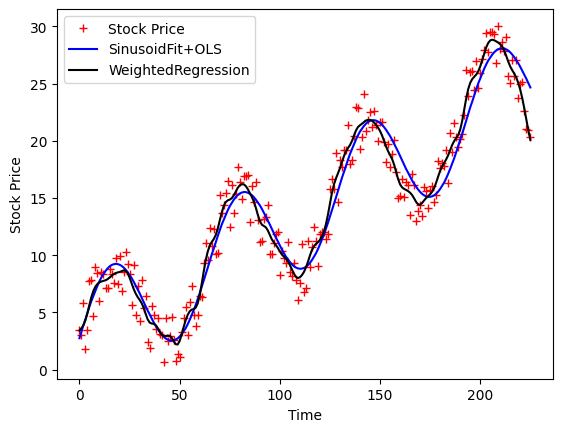

In [46]:
plt.plot(xx, y2.y, 'r+')
plt.plot(xx, yhat3, 'b-')
plt.plot(xx, y_preds, 'k-')
plt.ylabel('Stock Price')
plt.xlabel('Time')
plt.legend(['Stock Price', 'SinusoidFit+OLS', 'WeightedRegression'], loc='upper left')
plt.show()

### let's try the extrapolation usecase


In [47]:
# our range is 0-225, let's stretch the range to do extrapolation.
xx_extra = np.arange(0, 250, 1)

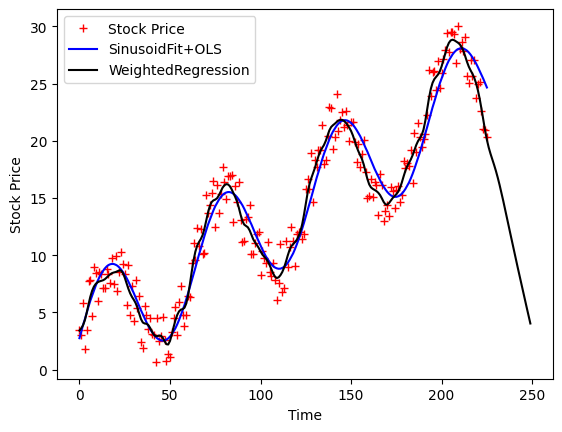

In [48]:
y_preds_extra = predict(xx_extra, xx, yy, tau=2)
plt.plot(xx, y2.y, 'r+')
plt.plot(xx, yhat3, 'b-')
plt.plot(xx_extra, y_preds_extra, 'k-')
plt.ylabel('Stock Price')
plt.xlabel('Time')
plt.legend(['Stock Price', 'SinusoidFit+OLS', 'WeightedRegression'], loc='upper left')
plt.show()

__clearly the extrapolation use is not working at all!!__

Nonetheless, for interpolation usecases, the locally-weighted regression model would be of greater help.  If you look at the number of parameters learned during the prediction of training data, we see that there are 2 parameter per data points and hence 2 * N parameters in total.  But, to make a prediction for one test point, we learn the model using the weighted neighbors and make the prediction for the supplied input. So, technically, the behaviour is parameter-less!  Also, the LWR can be considered as a variation of the kNN (lazy modeling).

When data is ${x_1, x_2, ..., x_m}$ and labels are ${y_1, y_2, ..., y_m}$, the dumbest estimate of output is given by $ y = \frac{1}{m}\sum_{i=1}^{m}y_i$.  A better way to modeling is to weight the labels according to the location (Watson, Nadaraya, 1964) as $y = \sum_{i=1}^m \alpha(x, x_i)y_i$, where $\alpha$ can be modeled as a kernel function $k(x_i, x)$ such as Gaussian (see above for the Gaussian weighting function).  It is worthy to note that the formation is of the type Query, Key, Value (as in Transformers).  Here $x$ is the *Query*, $x_i$ is the *Key* and $y_i$ is the *Value*.  We may extend the weighting function by normalizing it into $\alpha_i(x) = \frac{k(x_i, x)}{\sum_j k(x_j, x)}$. Using all the components the model of the regression line becomes $f(x) = \sum_i y_i \alpha_i(x) = \sum_i y_i \frac{k(x_i, x)}{\sum_j k(x_j, x)}$

In [49]:
# implementing the above idea.
def WReg(X_test, X, y, tau):
    preds = []
    for x_t in X_test:
        num = gaussian_kernel(x_t, X, tau)
        ratio = num / np.sum(num)
        pred = np.sum(ratio * y)
        preds.append(pred)
    return np.array(preds)

In [50]:
# making predictions
y_preds_v2 = WReg(xx,xx,yy,tau=2)
loss = SSE(y_preds_v2, yy)
print("Loss =", loss)

Loss = 364.2236169746395


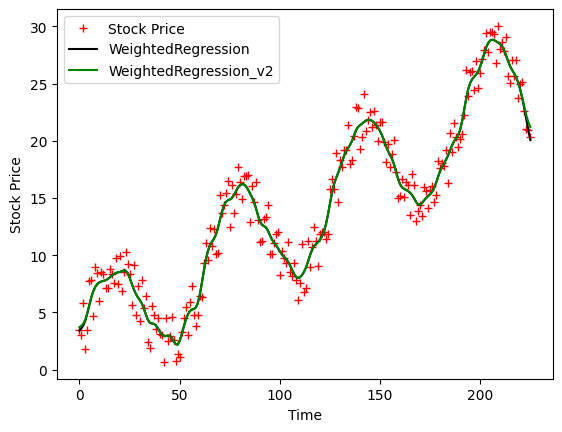

In [51]:
# plot and compare
plt.plot(xx, y2.y, 'r+')
plt.plot(xx, y_preds, 'k-')
plt.plot(xx, y_preds_v2, 'g-')
plt.ylabel('Stock Price')
plt.xlabel('Time')
plt.legend(['Stock Price', 'WeightedRegression', 'WeightedRegression_v2'], loc='upper left')
plt.show()

__The plots are identical for the same $\tau$ setting into both approaches. Green line is on top of the Black line, FYI.__